# Decoding The 3-Qubit Repetition Code

In this experiment, we decode the 3-qubit repetition code using ``mdopt``. Here, we demonstrate direct-error input decoding, which means that the decoder takes a Pauli error as input and outputs the most likely logical operator. After each run, the algorithm yields a probability distribution over the Pauli operators (I, X, Z, Y) to apply to the encoded logical qubit.

In [1]:
import numpy as np
import qecsim.paulitools as pt
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from tqdm import tqdm
from scipy.stats import sem

from mdopt.utils.utils import mpo_to_matrix
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.mps.utils import (
    inner_product,
    create_custom_product_state,
    create_simple_product_state,
)
from mdopt.optimiser.utils import (
    apply_constraints,
    ConstraintString,
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
    IDENTITY,
)

from examples.decoding.decoding import (
    custom_code_checks,
    custom_code_logicals,
    custom_code_logicals_sites,
    custom_code_constraint_sites,
    apply_bitflip_bias,
    apply_depolarising_bias,
    pauli_to_mps,
    decode_custom,
    css_code_stabilisers,
    multiply_pauli_strings,
    map_distribution_to_pauli,
    generate_pauli_error_string,
)
from examples.decoding.visualisation import plot_parity_check_mpo

Let us first define the code. Here, we won't be using `qecstruct` as in the other examples because it lacks the machinery we need. Instead, we define the code as a list of stabilizers and logical operators.

In [2]:
stabilizer_generators = [
    "XXI",
    "IXX",
]
x_logical_operators = [
    "XXX",
]
z_logical_operators = [
    "ZZZ",
]
logical_operators = x_logical_operators + z_logical_operators
num_qubits = len(stabilizer_generators[0])

Let us first take a look at the code in terms of the MPS sites where the checks will be applied.

In [3]:
checks = custom_code_checks(stabilizer_generators, logical_operators)

print("Stabilizer generators:")
for check in checks:
    print(check)

Stabilizer generators:
[2, 4]
[4, 6]


We now transform this into lists of sites where all the logical constraints are applied.

In [4]:
constraint_sites = custom_code_constraint_sites(
    stabilizer_generators, logical_operators
)

print("MPS constraint sites:")
for string in constraint_sites:
    print(string)

MPS constraint sites:
[[2], [], [3], [4]]
[[4], [], [5], [6]]


In [5]:
logicals = custom_code_logicals(x_logical_operators, z_logical_operators)

print("Logical operators:")
print(logicals[0])
print(logicals[1])

Logical operators:
[[2, 4, 6]]
[[3, 5, 7]]


In [6]:
logicals_sites = custom_code_logicals_sites(x_logical_operators, z_logical_operators)

print("MPS logical constraint sites:")
print(logicals_sites[0])
print(logicals_sites[1])

MPS logical constraint sites:
[[[0], [2, 4], [1, 3, 5], [6]]]
[[[1], [3, 5], [2, 4, 6], [7]]]


This quantum error correcting code is defined on $3$ physical qubits and has $2$ logical operators because it encodes $1$ logical qubit. This means we will need $3*2 + 2 = 8$ sites in our MPS.

In [7]:
num_logicals = len(x_logical_operators) + len(z_logical_operators)
num_sites = 2 * len(stabilizer_generators[0]) + num_logicals

assert num_sites == 8
assert num_logicals == 2

Now, let us define the initial state. First of all we will check that no error implies no correction. This means starting from the all-zero state followed by decoding will return the all-zero state for the logical operators (the final logical operator will thus be identity operator). Thus, we start from the all-zero state for the error and the $|+\rangle$ state for the logicals.

In [8]:
error_state = "0" * (num_sites - num_logicals)
logicals_state = "+" * num_logicals
state_string = logicals_state + error_state
error_mps = create_custom_product_state(
    string=state_string, tolerance=1e-17, form="Left-canonical"
)

The lists of sites in the previous cells identify the sites where we will apply the XOR constraints. However, the MPOs will also consist of other tensors, such as SWAPs (a.k.a. the tensors' legs crossings) and boundary XOR constraints. In what follows, we define the list of these auxiliary tensors.

In [9]:
constraints_tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
logicals_tensors = [COPY_LEFT, XOR_BULK, SWAP, XOR_RIGHT]

Now the fun part, MPS-MPO contraction. But first, we apply the bias channel to our error state. This is done to bias our output towards the received input. This is done by distributing the amplitude around the initial basis product state to other basis product states in the descending order by Hamming distance.

In [10]:
renormalise = True
sites_to_bias = list(range(num_logicals, num_sites))
error_mps = apply_bitflip_bias(
    mps=error_mps,
    prob_bias_list=0.01,
    sites_to_bias=sites_to_bias,
)

In [11]:
entropies, bond_dims = [], []

# for the X and the Z logicals
for i in [0, 1]:
    error_mps, entrps, bnd_dims = apply_constraints(
        error_mps,
        logicals_sites[i],
        logicals_tensors,
        cut=1e-17,
        chi_max=1e4,
        renormalise=renormalise,
        strategy="Naive",
        return_entropies_and_bond_dims=True,
    )
    entropies += entrps
    bond_dims += bnd_dims

# for the stabilizer checks
error_mps, entrps, bnd_dims = apply_constraints(
    error_mps,
    constraint_sites,
    constraints_tensors,
    cut=1e-17,
    chi_max=1e4,
    renormalise=renormalise,
    strategy="Naive",
    return_entropies_and_bond_dims=True,
)
entropies += entrps
bond_dims += bnd_dims

100%|██████████| 2/2 [00:00<00:00, 108.54it/s]


Let us now take a look at how the bond dimensions and entropies behave throughout the decoding process while applying the parity checks.

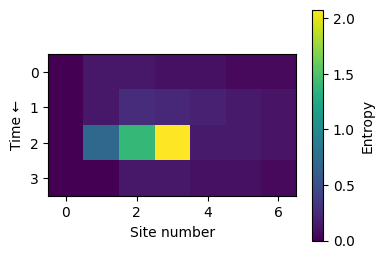

In [12]:
plt.figure(figsize=(4, 3))
plt.imshow(entropies, cmap="viridis")
plt.colorbar(label="Entropy")
plt.xlabel("Site number")
plt.ylabel("Time ←")
plt.show()

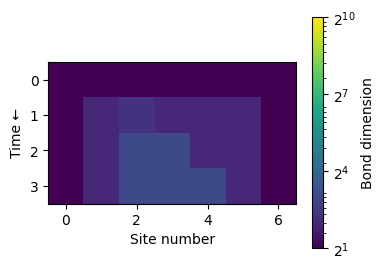

In [13]:
plt.figure(figsize=(4, 3))
plt.imshow(bond_dims, cmap="viridis", norm=LogNorm(vmin=2**1, vmax=2**10))
cbar = plt.colorbar(
    label="Bond dimension",
    format=FuncFormatter(lambda x, pos: f"$2^{{{int(np.log2(x))}}}$"),
    ticks=[2**i for i in range(1, 11, 3)],
)
plt.ylabel("Time ←")
plt.xlabel("Site number")
plt.show()

Let's now take a look at how the truncation error behaves for different bond dimension cutoffs. First, let's look at the bond dimensions appearing in the MPS if we do not impose any truncation.

In [14]:
print(error_mps.bond_dimensions)

[2, 4, 8, 8, 8, 4, 2]


In [15]:
bond_dims = [np.inf, 16, 8, 4]
inv_bond_dims = [1 / bd for bd in bond_dims]
errors = []
for chi in tqdm(bond_dims):
    errors.append(
        np.linalg.norm(
            error_mps.compress(
                chi_max=chi, renormalise=True, return_truncation_errors=True
            )[1]
        )
    )

100%|██████████| 4/4 [00:00<00:00, 846.39it/s]


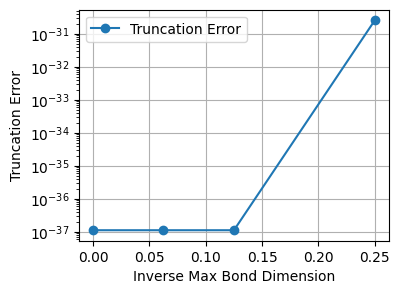

In [16]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, errors, marker="o", label="Truncation Error")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Truncation Error")
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()

Now, we marginalise over the message bits to get the probability distribution over the four possibilities of a logical operator: $I$, $X$, $Z$, $Y$.

In [17]:
sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
logical_mps = error_mps.marginal(
    sites_to_marginalise=sites_to_marginalise,
    canonicalise=False,
)

In [18]:
logicals = logical_mps.dense(flatten=True, renormalise=True, norm=1)
print(logicals)

[7.72235375e-01 2.26750465e-01 7.83965408e-04 2.30194740e-04]


For the record, we're hunting for the most likely logical operator to be the identity operator. So that's it, we see the biggest probability assigned to the identity operator. Let's see how the probabilities of the four operators change as we change the bond dimension cutoff.

In [19]:
strategy = "Optimised"
logical_values = [[] for _ in range(4)]

for max_bond_dim in tqdm(bond_dims):
    error_state = "0" * (num_sites - num_logicals)
    logicals_state = "+" * num_logicals
    state_string = logicals_state + error_state
    error_mps = create_custom_product_state(
        string=state_string, tolerance=1e-17, form="Right-canonical"
    )

    error_mps = apply_bitflip_bias(
        mps=error_mps,
        prob_bias_list=0.1,
        sites_to_bias=sites_to_bias,
    )
    for i in [0, 1]:
        error_mps = apply_constraints(
            error_mps,
            logicals_sites[i],
            logicals_tensors,
            renormalise=renormalise,
            strategy=strategy,
            chi_max=max_bond_dim,
            silent=True,
            cut=1e-17,
        )
    error_mps = apply_constraints(
        error_mps,
        constraint_sites,
        constraints_tensors,
        renormalise=renormalise,
        strategy=strategy,
        chi_max=max_bond_dim,
        silent=True,
        cut=1e-17,
    )

    sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
    logical = error_mps.marginal(
        sites_to_marginalise=sites_to_marginalise,
        canonicalise=False,
    ).dense(flatten=True, renormalise=True, norm=1)

    for i in range(4):
        logical_values[i].append(logical[i])

100%|██████████| 4/4 [00:00<00:00, 201.31it/s]


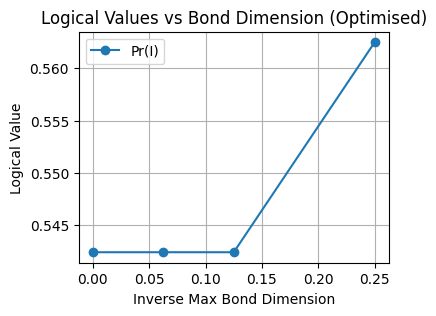

In [20]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, logical_values[0], marker="o", label=f"Pr(I)")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Logical Value")
plt.title("Logical Values vs Bond Dimension (Optimised)")
plt.grid(True)
plt.legend()
plt.show()

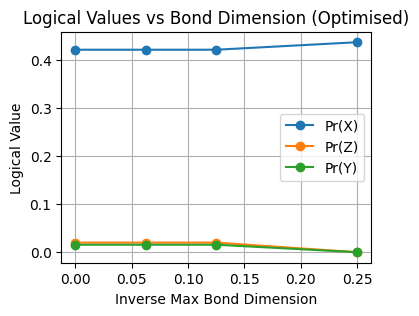

In [21]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, logical_values[1], marker="o", label=f"Pr(X)")
plt.plot(inv_bond_dims, logical_values[2], marker="o", label=f"Pr(Z)")
plt.plot(inv_bond_dims, logical_values[3], marker="o", label=f"Pr(Y)")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Logical Value")
plt.title("Logical Values vs Bond Dimension (Optimised)")
plt.grid(True)
plt.legend()
plt.show()

Because this system is a small one, we can compute the failure probability exactly. Here, we are talking about the bitflip channel which is parametrised by probability $p$. Then, the failure probability is equal to the probability of 2- or 3-qubit error occurence. The probability of 2-qubit error is $3p^2(1-p)$ and the probability of 3-qubit error is $p^3$. The total failure probability is the sum of these two probabilities: $3p^2 - 2p^3$. Our Monte-Carlo simulations should yield exactly the same result.

In [22]:
NUM_EXPERIMENTS = 10000
SEED = 123
NUM_QUBITS = 3
error_rates = np.linspace(0.01, 0.50, 23)
max_bond_dims = [np.inf, 16, 8, 4]

# Initialize seed sequence
seed_seq = np.random.SeedSequence(SEED)

# Generate errors
errors = {}
for ERROR_RATE in error_rates:
    errors[ERROR_RATE] = []
    for _ in range(NUM_EXPERIMENTS):
        rng = np.random.default_rng(seed_seq.spawn(1)[0])

        error = generate_pauli_error_string(
            num_qubits=NUM_QUBITS,
            error_rate=ERROR_RATE,
            rng=rng,
            error_model="Bitflip",
        )
        errors[ERROR_RATE].append(error)

# Decode and gather statistics
failures_statistics = {}
for CHI_MAX in max_bond_dims:
    print(f"Processing CHI_MAX = {CHI_MAX}")
    for ERROR_RATE in tqdm(error_rates):
        failures = []

        for error in errors[ERROR_RATE]:
            _, success = decode_custom(
                stabilizers=stabilizer_generators,
                x_logicals=x_logical_operators,
                z_logicals=z_logical_operators,
                error=error,
                chi_max=CHI_MAX,
                bias_type="Bitflip",
                bias_prob=0.1,
                cut=1e-17,
                tolerance=1e-17,
                renormalise=True,
                silent=True,
                contraction_strategy="Naive",
            )
            failures.append(1 - success)

        failures_statistics[CHI_MAX, ERROR_RATE] = failures

Processing CHI_MAX = inf


100%|██████████| 23/23 [08:11<00:00, 21.37s/it]


Processing CHI_MAX = 16


100%|██████████| 23/23 [07:51<00:00, 20.50s/it]


Processing CHI_MAX = 8


100%|██████████| 23/23 [07:53<00:00, 20.57s/it]


Processing CHI_MAX = 4


100%|██████████| 23/23 [07:52<00:00, 20.56s/it]


In [23]:
failure_rates = {}
error_bars = {}

for CHI_MAX in max_bond_dims:
    for ERROR_RATE in error_rates:
        failure_rates[CHI_MAX, ERROR_RATE] = np.mean(
            failures_statistics[CHI_MAX, ERROR_RATE]
        )
        error_bars[CHI_MAX, ERROR_RATE] = sem(failures_statistics[CHI_MAX, ERROR_RATE])

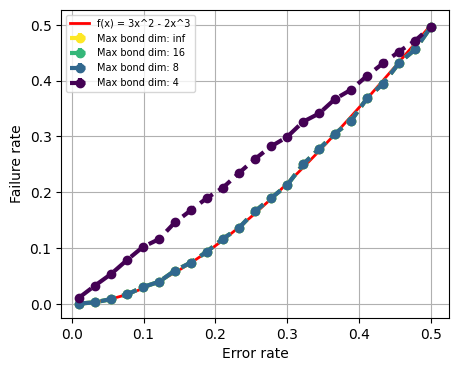

In [24]:
plt.figure(figsize=(5, 4))

green_cmap = colormaps["viridis_r"]
norm = Normalize(vmin=0, vmax=len(max_bond_dims) - 1)
f = lambda p: 3 * p**2 - 2 * p**3

for index, CHI_MAX in enumerate(max_bond_dims):
    plt.errorbar(
        error_rates,
        [failure_rates[CHI_MAX, ERROR_RATE] for ERROR_RATE in error_rates],
        yerr=[error_bars[CHI_MAX, ERROR_RATE] for ERROR_RATE in error_rates],
        fmt="o--",
        label=f"Max bond dim: {CHI_MAX}",
        linewidth=3,
        color=green_cmap(norm(index)),
    )

plt.plot(
    error_rates,
    [f(error_rate) for error_rate in error_rates],
    label="f(x) = 3x^2 - 2x^3",
    color="red",
    linewidth=2,
)

plt.legend(fontsize=7)
plt.xlabel("Error rate")
plt.ylabel("Failure rate")
plt.grid()

plt.show()

This is perfect, we see that the Monte Carlo simulation results are in perfect agreement with the analytical expression apart from bond dimension 4 which is just too agressive of a truncation.